In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [7]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [8]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [9]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [10]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 2.352170 drop: 2.356615 plain: 2.337576
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 2.063507 drop: 2.290401 plain: 2.295299
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 1.792110 drop: 2.199280 plain: 2.276429
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 1.485822 drop: 1.753839 plain: 2.014123
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 1.120510 drop: 1.094961 plain: 1.478905
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 0.932776 drop: 0.906845 plain: 1.113966
Test set:
bn: Loss: 0.9282	Accuracy: 8995.0/10000 (90%)
drop: Loss: 0.9123	Accuracy: 7864.0/10000 (79%)
plain: Loss: 1.1331	Accuracy: 7709.0/10000 (77%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.894800 drop: 0.901428 plain: 1.137596
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 0.762365 drop: 0.708140 plain: 0.856687
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 0.538216 drop: 0.536781 plain: 0.594537
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 0.452620 drop: 0.413837 plain: 0.45

Train Epoch: 13 [30000/50000 (60%)]	Losses bn: 0.056000 drop: 0.088203 plain: 0.074773
Train Epoch: 13 [40000/50000 (80%)]	Losses bn: 0.111917 drop: 0.154723 plain: 0.147264
Train Epoch: 13 [50000/50000 (100%)]	Losses bn: 0.223982 drop: 0.261236 plain: 0.212571
Test set:
bn: Loss: 0.0705	Accuracy: 9816.0/10000 (98%)
drop: Loss: 0.1253	Accuracy: 9638.0/10000 (96%)
plain: Loss: 0.1154	Accuracy: 9656.0/10000 (97%)

Train Epoch: 14 [0/50000 (0%)]	Losses bn: 0.136793 drop: 0.245021 plain: 0.224402
Train Epoch: 14 [10000/50000 (20%)]	Losses bn: 0.026522 drop: 0.097628 plain: 0.073438
Train Epoch: 14 [20000/50000 (40%)]	Losses bn: 0.020849 drop: 0.064640 plain: 0.055170
Train Epoch: 14 [30000/50000 (60%)]	Losses bn: 0.019512 drop: 0.065731 plain: 0.062946
Train Epoch: 14 [40000/50000 (80%)]	Losses bn: 0.027267 drop: 0.056749 plain: 0.050945
Train Epoch: 14 [50000/50000 (100%)]	Losses bn: 0.031496 drop: 0.093052 plain: 0.073770
Test set:
bn: Loss: 0.0666	Accuracy: 9822.0/10000 (98%)
drop: Loss

Train Epoch: 25 [50000/50000 (100%)]	Losses bn: 0.008499 drop: 0.019498 plain: 0.018378
Test set:
bn: Loss: 0.0513	Accuracy: 9849.0/10000 (98%)
drop: Loss: 0.0776	Accuracy: 9777.0/10000 (98%)
plain: Loss: 0.0742	Accuracy: 9795.0/10000 (98%)

Train Epoch: 26 [0/50000 (0%)]	Losses bn: 0.040596 drop: 0.081399 plain: 0.080019
Train Epoch: 26 [10000/50000 (20%)]	Losses bn: 0.008534 drop: 0.009514 plain: 0.010706
Train Epoch: 26 [20000/50000 (40%)]	Losses bn: 0.008689 drop: 0.026713 plain: 0.017083
Train Epoch: 26 [30000/50000 (60%)]	Losses bn: 0.004741 drop: 0.016178 plain: 0.013833
Train Epoch: 26 [40000/50000 (80%)]	Losses bn: 0.010294 drop: 0.029654 plain: 0.018853
Train Epoch: 26 [50000/50000 (100%)]	Losses bn: 0.003678 drop: 0.008510 plain: 0.007372
Test set:
bn: Loss: 0.0494	Accuracy: 9852.0/10000 (99%)
drop: Loss: 0.0760	Accuracy: 9791.0/10000 (98%)
plain: Loss: 0.0726	Accuracy: 9802.0/10000 (98%)

Train Epoch: 27 [0/50000 (0%)]	Losses bn: 0.036696 drop: 0.082990 plain: 0.089826
Trai

Train Epoch: 38 [10000/50000 (20%)]	Losses bn: 0.012876 drop: 0.055818 plain: 0.043001
Train Epoch: 38 [20000/50000 (40%)]	Losses bn: 0.004108 drop: 0.020242 plain: 0.020475
Train Epoch: 38 [30000/50000 (60%)]	Losses bn: 0.006567 drop: 0.023985 plain: 0.020331
Train Epoch: 38 [40000/50000 (80%)]	Losses bn: 0.010792 drop: 0.056587 plain: 0.027068
Train Epoch: 38 [50000/50000 (100%)]	Losses bn: 0.009173 drop: 0.037480 plain: 0.037886
Test set:
bn: Loss: 0.0441	Accuracy: 9862.0/10000 (99%)
drop: Loss: 0.0640	Accuracy: 9822.0/10000 (98%)
plain: Loss: 0.0608	Accuracy: 9824.0/10000 (98%)

Train Epoch: 39 [0/50000 (0%)]	Losses bn: 0.006564 drop: 0.020043 plain: 0.016190
Train Epoch: 39 [10000/50000 (20%)]	Losses bn: 0.013149 drop: 0.027131 plain: 0.018770
Train Epoch: 39 [20000/50000 (40%)]	Losses bn: 0.006724 drop: 0.031203 plain: 0.057274
Train Epoch: 39 [30000/50000 (60%)]	Losses bn: 0.019475 drop: 0.032067 plain: 0.030740
Train Epoch: 39 [40000/50000 (80%)]	Losses bn: 0.011176 drop: 0.030

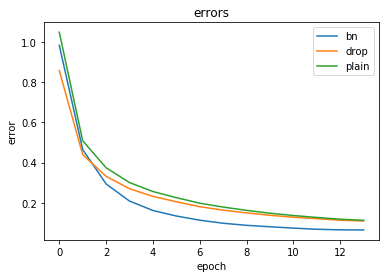

In [11]:
plot_graphs(test_log, 'loss')

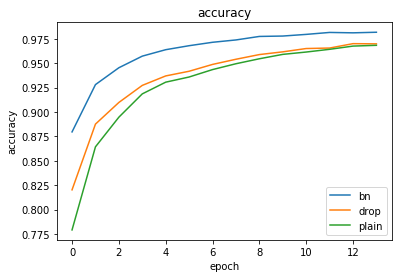

In [12]:
plot_graphs(test_log, 'accuracy')

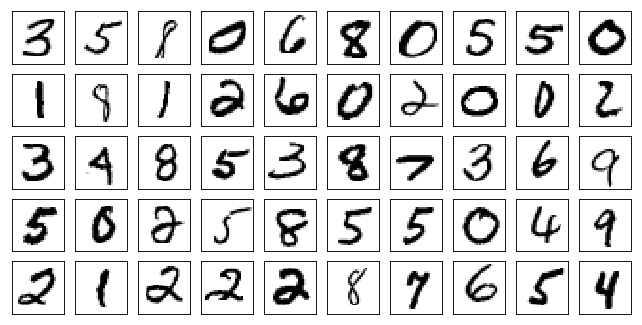

tensor([-13.8609,  -8.9052,  -4.7882,   9.8132, -12.5249,   0.6174, -12.2183,
         -7.7492,  -2.9126,  -3.9947], grad_fn=<SelectBackward>)


In [11]:
data, label = next(iter(train_loader))
plot_mnist(data.data.numpy(), (5, 10))
output = models['bn'](data)
output.size()
print(output[0])
#to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
#plot_mnist(to_plot, (5, 10))

### Подгонка картинки или Сделать оптимизацию изображения под активацию сверточных нейронов классификатора

In [86]:
path='./MNIST_data'
from torch.utils.data import DataLoader
train_dataset = torchvision.datasets.MNIST(root = path, train=True, transform=mnist_transform, download=True) 
train_loader_1 = DataLoader(dataset=train_dataset, batch_size=1,shuffle=True) 
data_1, label_1 = next(iter(train_loader_1))

In [87]:
#УСТАРЕЛО Tensors and Variables have merged in 0.4.0
# Обернем в Variable и потребуем градиентов - 
#from torch.autograd import Variable
#data_t = Variable(torch.FloatTensor( data_1 ), requires_grad=True)

In [88]:
data_1 = torch.tensor( data_1 , requires_grad= True )

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [102]:
# Целевой пусть будет циферка :
target = torch.tensor([2])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


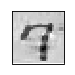

tensor(13.5156)


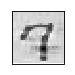

tensor(0.0108)


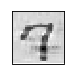

tensor(0.0066)


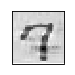

tensor(0.0051)


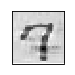

tensor(0.0041)


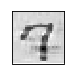

tensor(0.0035)


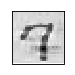

tensor(0.0031)


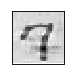

tensor(0.0028)


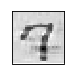

tensor(0.0026)


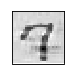

tensor(0.0024)


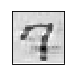

tensor(0.0022)


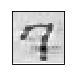

tensor(0.0021)


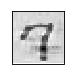

tensor(0.0020)


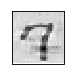

tensor(0.0018)


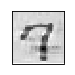

tensor(0.0017)


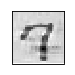

tensor(0.0017)


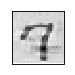

tensor(0.0016)


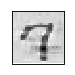

tensor(0.0015)


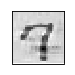

tensor(0.0015)


KeyboardInterrupt: 

In [103]:
# Cross entropy
lr = 0.3
output_ar = []
loss_arr = []
grads = []
data_1 = torch.tensor( data_1 , requires_grad= True )
for i in range(0,200000):
    output_1 = model(data_1)
    loss_t = F.cross_entropy(output_1, target)
    loss_t.backward()
    data_1.data = data_1.data - (lr*data_1.grad.data)
    #data_1.grad.data = torch.zeros(data_1.grad.size())
    data_1.grad.data.zero_()
    if i % 100 == 0:
        plot_mnist(data_1.data.numpy(), (5, 10))
        print(loss_t.data)
plot_mnist(data_1.data.numpy(), (5, 10))

In [104]:
# Проверка, что это все таки та цифра, которую ожидали :)
output_o = model(data_1)
print(output_o)

tensor([[ -9.8237,  -6.7800,   4.3994,  -4.2142,  -7.5151,  -3.4171, -10.8305,
          -2.9775,  -4.4366,  -5.4666]], grad_fn=<AddmmBackward>)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


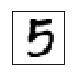

tensor(1.9324)


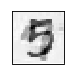

tensor(0.8987)


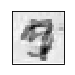

tensor(0.4179)


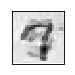

tensor(0.1944)


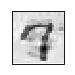

tensor(0.0904)


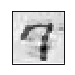

tensor(0.0420)


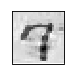

tensor(0.0195)


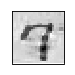

tensor(0.0091)


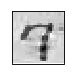

tensor(0.0042)


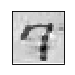

tensor(0.0020)


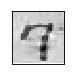

tensor(0.0009)


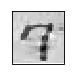

tensor(0.0004)


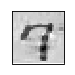

tensor(0.0002)


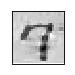

tensor(9.1971e-05)


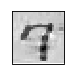

tensor(4.2772e-05)


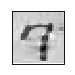

tensor(1.9892e-05)


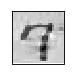

tensor(9.2513e-06)


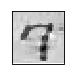

tensor(4.3030e-06)


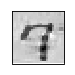

tensor(2.0016e-06)


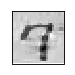

tensor(9.3166e-07)


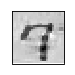

tensor(4.3369e-07)


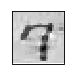

tensor(2.0238e-07)


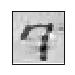

tensor(9.4687e-08)


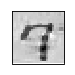

tensor(4.4676e-08)


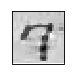

tensor(2.1793e-08)


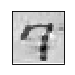

tensor(1.0434e-08)


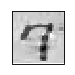

tensor(5.6763e-09)


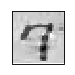

tensor(4.2232e-09)


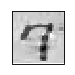

tensor(3.6092e-09)


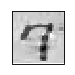

tensor(3.3455e-09)


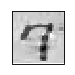

tensor(3.2395e-09)


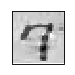

tensor(3.1976e-09)


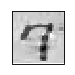

tensor(3.1903e-09)


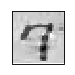

tensor(3.1879e-09)


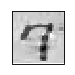

tensor(3.1874e-09)


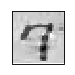

tensor(3.1873e-09)


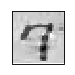

tensor(3.1873e-09)


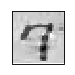

tensor(3.1873e-09)


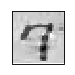

tensor(3.1873e-09)


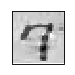

tensor(3.1873e-09)


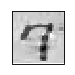

tensor(3.1873e-09)


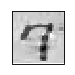

tensor(3.1873e-09)


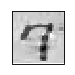

tensor(3.1873e-09)


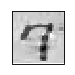

tensor(3.1873e-09)


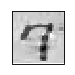

tensor(3.1873e-09)


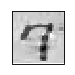

tensor(3.1873e-09)


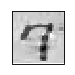

tensor(3.1873e-09)


KeyboardInterrupt: 

In [101]:
# For fun MSE_loss 
lr = 0.3
output_ar = []
loss_arr = []
grads = []
data_2,label = next(iter(train_loader_1))
data_t = torch.tensor( data_2 , requires_grad=True)
for i in range(0,200000):
    #data_t.grad.data.zero_
    #output_o = model(data_t)
    loss_t = F.mse_loss(data_t, data_1)
    loss_t.backward()
    data_t.data = data_t.data - (lr*data_t.grad.data)
    #grads.append(data_t.grad.data)
    loss_arr.append(loss_t.data)
    #output_ar.append(output_o)
    data_t.grad.data.zero_()
    #print(data_t.grad.data)
    if i % 500 == 0:
        plot_mnist(data_t.data.numpy(), (5, 10))
        print(loss_t.data)
plot_mnist(data_t.data.numpy(), (5, 10))